In [1]:
import pandas as pd
import os
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


# Investigate Meta Data Field

In [17]:
meta_dir = '.\\'

In [20]:
meta_files = glob.glob("*_text_meta_*.txt")
meta_file_list = []
for meta_file in meta_files:
    df = pd.read_table(meta_file,index_col=None, header=0)
    meta_file_list.append(df)
    
print meta_files
meta_frame = pd.concat(meta_file_list)

[           ID  Fwy Dir  District  County     City State_PM  Abs_PM   Latitude  \
0     1100313    5   N        11      73  66000.0  R22.324  22.215  32.791540   
1     1100323    5   N        11      73  66000.0  R34.142  34.033  32.950106   
2     1100326    5   N        11      73  66000.0  R36.232  36.123  32.979357   
3     1100330    5   N        11      73  66000.0   R37.37  37.261  32.995494   
4     1100333    5   N        11      73  22678.0   R38.54  38.431  33.010364   
5     1100340    5   N        11      73  11194.0  R47.165  47.056  33.123940   
6     1100348    5   S        11      73  66000.0  R18.931  18.822  32.746784   
7     1100353    5   S        11      73  66000.0  R22.082  21.973  32.788012   
8     1100363    5   S        11      73  66000.0   R26.73  26.621  32.848532   
9     1100369    5   S        11      73  66000.0  R28.464  28.355  32.872590   
10    1100372    5   S        11      73  66000.0  R32.805  32.663  32.930855   
11    1100377    5   S     

In [21]:
# sanity check to ensure files have been found
meta_matches[:5]

['./d11_text_meta_2015_12_17.txt']

In [32]:
# check for duplicate ID values.
meta_frame[meta_frame.ID.duplicated() == True]

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4


In [24]:
meta_frame.columns

Index([u'ID', u'Fwy', u'Dir', u'District', u'County', u'City', u'State_PM',
       u'Abs_PM', u'Latitude', u'Longitude', u'Length', u'Type', u'Lanes',
       u'Name', u'User_ID_1', u'User_ID_2', u'User_ID_3', u'User_ID_4'],
      dtype='object')

In [26]:
# the type in the meta data are just the detector types.  Need to analyze the "change" that cohort 1 referred to
meta_frame[['ID','Type']] # TODO: assuming meta and 5min agree on freeway type...check?

,ID,Type
0,1100313,FR
1,1100323,FR
2,1100326,FR
3,1100330,FR
4,1100333,FR
5,1100340,FR
6,1100348,FR
7,1100353,FR
8,1100363,FR
9,1100369,FR


# load 5 min data

The purpose of this section will be to create a new csv file.  The reason for doing this is to try to do the processing one time and then free up memory.  The current approach is to start off with uncompressed files (to save on memory / processing within the notebook).  Once this is complete we will iterate over all of the files in question.  Notice that the dataframe will be dropping columns as each individual file is loaded.  This was done to try and conserve memory.  The 2015 year in text is 40 GB.  Once all of the file are read (and unnecessary columns dropped) a single dataframe will be constructed.

After the single dataframe is constructed it will be written out to a csv file.

After that point the csv file is what should be read into the notebook.  Unless new data is needed the pickle file should be sufficient.

The expected csv file will be approximately 12 GB. After that point we will hopefully do our statistics and then again generate a much smaller file.

In [ ]:
# 12 base fields
# 5 fields per lane
# 8 lanes
# 40 + 12

# File has 52 columns

In [2]:
# need to come up with dynamic way of doing this
five_min_base_header = ['Timestamp', 'Station', 'District', 'Freeway #', 'Direction', 'Lane Type', 'Station Length',
                        'Samples', '% Observed', 'Total Flow', 'Avg Occupancy', 'Avg Speed']
five_min_extra_header = ['Lane %s Samples', 'Lane %s Flow', 'Lane %s Avg Occ', 'Lane %s Avg Speed', 'Lane %s Observed']
header = five_min_base_header
max_lanes = 8
for i in range(1, max_lanes + 1):
    new_header = [item % i for item in five_min_extra_header]
    header += new_header
    
print header

['Timestamp', 'Station', 'District', 'Freeway #', 'Direction', 'Lane Type', 'Station Length', 'Samples', '% Observed', 'Total Flow', 'Avg Occupancy', 'Avg Speed', 'Lane 1 Samples', 'Lane 1 Flow', 'Lane 1 Avg Occ', 'Lane 1 Avg Speed', 'Lane 1 Observed', 'Lane 2 Samples', 'Lane 2 Flow', 'Lane 2 Avg Occ', 'Lane 2 Avg Speed', 'Lane 2 Observed', 'Lane 3 Samples', 'Lane 3 Flow', 'Lane 3 Avg Occ', 'Lane 3 Avg Speed', 'Lane 3 Observed', 'Lane 4 Samples', 'Lane 4 Flow', 'Lane 4 Avg Occ', 'Lane 4 Avg Speed', 'Lane 4 Observed', 'Lane 5 Samples', 'Lane 5 Flow', 'Lane 5 Avg Occ', 'Lane 5 Avg Speed', 'Lane 5 Observed', 'Lane 6 Samples', 'Lane 6 Flow', 'Lane 6 Avg Occ', 'Lane 6 Avg Speed', 'Lane 6 Observed', 'Lane 7 Samples', 'Lane 7 Flow', 'Lane 7 Avg Occ', 'Lane 7 Avg Speed', 'Lane 7 Observed', 'Lane 8 Samples', 'Lane 8 Flow', 'Lane 8 Avg Occ', 'Lane 8 Avg Speed', 'Lane 8 Observed']


In [188]:
# Note: because I have space I unzipped all of the files.  Difference code is needed to decompress on the fly.
jan_2016_path = "../../cohort2/output_unzipped/station_5min/2016/d11/*_text_station_5min_2016_01*.txt"
all_2015_path = "../../cohort2/output_unzipped/station_5min/2015/d11/*_text_station_5min_*.txt"
import_path = all_2015_path

columns_to_keep = ['Timestamp', 'Station', 'District', 'Freeway #', 'Direction', 'Lane Type', 'Station Length',
                   'Samples', '% Observed', 'Total Flow', 'Avg Occupancy', 'Avg Speed']

def import_data(import_path, columns_to_keep=[]):
    five_min_files = glob.glob(import_path)
    print five_min_files[0:5]
    five_min_file_list = []
    total = len(five_min_files)
    for index in range(0, total):
        five_min_file = five_min_files[index]
        if index % (total/10) == 0:
            print "{0:.2f}".format(index/float(total))
        df = pd.read_csv(five_min_file,index_col=None, header=None, names=header)
        # drop columns to reduce size
        if columns_to_keep:
            df = df[columns_to_keep]
        five_min_file_list.append(df)

    five_min_frame = pd.concat(five_min_file_list)
    return five_min_frame

In [189]:
# shouldn't run this cell
# five_min_frame = import_data(import_path, columns_to_keep)

['../../cohort2/output_unzipped/station_5min/2015/d11/d11_text_station_5min_2015_01_01.txt', '../../cohort2/output_unzipped/station_5min/2015/d11/d11_text_station_5min_2015_01_02.txt', '../../cohort2/output_unzipped/station_5min/2015/d11/d11_text_station_5min_2015_01_03.txt', '../../cohort2/output_unzipped/station_5min/2015/d11/d11_text_station_5min_2015_01_04.txt', '../../cohort2/output_unzipped/station_5min/2015/d11/d11_text_station_5min_2015_01_05.txt']
0.00
0.10
0.20
0.30
0.39
0.49
0.59
0.69
0.79
0.89
0.99


In [192]:
# five_min_frame.to_csv('five_min_frame.csv')

In [ ]:
five_min_frame = pd.read_csv('five_min_frame.csv')

In [193]:
# if % Observed != 100 then some of the data is imputed
# there are specific columns that designate which columns are imputed
five_min_frame.head().T

,0,1,2,3,4
Timestamp,01/01/2015 00:00:00,01/01/2015 00:00:00,01/01/2015 00:00:00,01/01/2015 00:00:00,01/01/2015 00:00:00
Station,1100313,1100323,1100326,1100330,1100333
District,11,11,11,11,11
Freeway #,5,5,5,5,5
Direction,N,N,N,N,N
Lane Type,FR,FR,FR,FR,FR
Station Length,NaN,NaN,NaN,NaN,NaN
Samples,10,20,20,20,10
% Observed,100,0,100,100,100
Total Flow,16,NaN,11,7,3


In [194]:
# the lane types found in the 1st month of data
# - CD (Coll/Dist) <-- only 1 so don't care...
# - CH (Conventional Highway)
# - FF (Fwy-Fwy connector)
# - FR (Off Ramp)
# - HV (HOV)
# - ML (Mainline)
# - OR (On Ramp)
five_min_frame['Lane Type'].unique()

array(['FR', 'ML', 'OR', 'HV', 'FF', 'CH', 'CD'], dtype=object)

# Fields vs Freeway Type
Looks like all of the fields in the 5 min data don't relate to all of the freeway types equally.

Types that don't include Occupancy, Speed, Station Length
CH
FR
OR

Types that don't include Speed, Station Length
FF

Types that include Occupancy and Speed data (ie: have all field types)
ML, HV

Note: Lane N Observed is a 0 when no data exists for the lane, unlike other fields which are "blank" and therefore NaN

In [195]:
# five_min_frame[five_min_frame['Lane Type'] == 'CH'].head().T

,539,660,1083,1226,1227
Timestamp,01/01/2015 00:00:00,01/01/2015 00:00:00,01/01/2015 00:00:00,01/01/2015 00:00:00,01/01/2015 00:00:00
Station,1111515,1113641,1119449,1121657,1121663
District,11,11,11,11,11
Freeway #,8,78,78,67,67
Direction,W,E,W,N,S
Lane Type,CH,CH,CH,CH,CH
Station Length,NaN,NaN,NaN,NaN,NaN
Samples,20,20,30,10,10
% Observed,100,100,100,100,100
Total Flow,22,18,15,2,1


In [9]:
# five_min_frame[five_min_frame['Lane Type'] == 'CH'].describe().T

,count,mean,std,min,25%,50%,75%,max
Station,58464.0,1.118752e+06,4016.305378,1111515.0,1113641.0,1121657.0,1121667.0,1121671.0
District,58464.0,1.100000e+01,0.000000,11.0,11.0,11.0,11.0,11.0
Freeway #,58464.0,6.171429e+01,22.448318,8.0,67.0,67.0,78.0,78.0
Station Length,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Samples,58464.0,1.065776e+01,9.961029,0.0,0.0,10.0,20.0,30.0
% Observed,58464.0,6.015497e+01,45.414013,0.0,0.0,100.0,100.0,100.0
Total Flow,39080.0,5.439442e+01,43.709367,0.0,NaN,NaN,NaN,231.0
Avg Occupancy,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Avg Speed,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lane 1 Samples,58464.0,5.323430e+00,4.975855,0.0,0.0,10.0,10.0,10.0


In [16]:
# five_min_frame[five_min_frame['Lane Type'] == 'FF'].head().T

,440,578,592,593,596
Timestamp,01/01/2016 00:00:00,01/01/2016 00:00:00,01/01/2016 00:00:00,01/01/2016 00:00:00,01/01/2016 00:00:00
Station,1108675,1113026,1113254,1113258,1113270
District,11,11,11,11,11
Freeway #,15,5,805,805,94
Direction,N,S,S,N,E
Lane Type,FF,FF,FF,FF,FF
Station Length,NaN,NaN,NaN,NaN,NaN
Samples,20,0,20,20,20
% Observed,100,0,50,50,100
Total Flow,6,NaN,6,4,17


In [10]:
# five_min_frame[five_min_frame['Lane Type'] == 'FF'].describe().T

,count,mean,std,min,25%,50%,75%,max
Station,392544.0,1.119412e+06,4353.760312,1108675.0,1115666.0,1120370.0,1122517.0,1126037.000
District,392544.0,1.100000e+01,0.000000,11.0,11.0,11.0,11.0,11.000
Freeway #,392544.0,1.996383e+02,317.151917,5.0,5.0,15.0,125.0,805.000
Station Length,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Samples,392544.0,1.407707e+01,7.108371,0.0,10.0,20.0,20.0,20.000
% Observed,392544.0,7.841312e+01,38.646458,0.0,50.0,100.0,100.0,100.000
Total Flow,323441.0,6.301098e+01,56.809830,0.0,NaN,NaN,NaN,368.000
Avg Occupancy,323441.0,4.140050e-02,0.052903,0.0,NaN,NaN,NaN,0.831
Avg Speed,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lane 1 Samples,375840.0,8.381497e+00,3.635192,0.0,NaN,NaN,NaN,10.000


In [13]:
# five_min_frame[five_min_frame['Lane Type'] == 'FR'].head().T

,0,1,2,3,4
Timestamp,01/01/2016 00:00:00,01/01/2016 00:00:00,01/01/2016 00:00:00,01/01/2016 00:00:00,01/01/2016 00:00:00
Station,1100313,1100323,1100326,1100330,1100333
District,11,11,11,11,11
Freeway #,5,5,5,5,5
Direction,N,N,N,N,N
Lane Type,FR,FR,FR,FR,FR
Station Length,NaN,NaN,NaN,NaN,NaN
Samples,10,20,20,20,10
% Observed,100,0,100,100,100
Total Flow,8,NaN,12,12,4


In [11]:
# five_min_frame[five_min_frame['Lane Type'] == 'FR'].describe().T

,count,mean,std,min,25%,50%,75%,max
Station,1912608.0,1.110810e+06,8569.637740,1100313.0,1100706.0,1113586.0,1114022.0,1125987.0
District,1912608.0,1.100000e+01,0.000000,11.0,11.0,11.0,11.0,11.0
Freeway #,1912608.0,1.720044e+02,294.975474,5.0,8.0,15.0,94.0,905.0
Station Length,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Samples,1912608.0,1.537703e+01,6.796890,0.0,10.0,20.0,20.0,20.0
% Observed,1912608.0,7.703764e+01,40.391770,0.0,50.0,100.0,100.0,100.0
Total Flow,1526014.0,2.591114e+01,27.009245,0.0,NaN,NaN,NaN,359.0
Avg Occupancy,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Avg Speed,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lane 1 Samples,1887552.0,8.929486e+00,3.051794,0.0,NaN,NaN,NaN,10.0


In [17]:
# five_min_frame[five_min_frame['Lane Type'] == 'HV'].head().T

,219,851,1000,1012,1069
Timestamp,01/01/2016 00:00:00,01/01/2016 00:00:00,01/01/2016 00:00:00,01/01/2016 00:00:00,01/01/2016 00:00:00
Station,1108436,1115829,1119284,1119532,1120107
District,11,11,11,11,11
Freeway #,5,15,5,5,5
Direction,N,N,S,S,N
Lane Type,HV,HV,HV,HV,HV
Station Length,0.609,1.347,0.784,0.901,1.048
Samples,10,20,10,10,10
% Observed,100,100,100,100,100
Total Flow,0,7,3,1,0


In [12]:
# five_min_frame[five_min_frame['Lane Type'] == 'HV'].describe().T

,count,mean,std,min,25%,50%,75%,max
Station,726624.0,1.123508e+06,2863.953904,1108436.000,1.121154e+06,1.125280e+06,1.125911e+06,1.125993e+06
District,726624.0,1.100000e+01,0.000000,11.000,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01
Freeway #,726624.0,2.854598e+02,376.932547,5.000,1.500000e+01,1.500000e+01,8.050000e+02,8.050000e+02
Station Length,726624.0,1.150667e+00,0.800399,0.139,5.910000e-01,9.000000e-01,1.347000e+00,3.204000e+00
Samples,726624.0,1.243434e+01,7.012735,0.000,1.000000e+01,1.000000e+01,2.000000e+01,2.000000e+01
% Observed,726624.0,8.056023e+01,38.464749,0.000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
Total Flow,726624.0,5.113320e+01,53.826824,0.000,1.000000e+01,3.500000e+01,7.600000e+01,4.500000e+02
Avg Occupancy,726624.0,3.338618e-02,0.043780,0.000,6.000000e-03,2.100000e-02,4.480000e-02,7.050000e-01
Avg Speed,726624.0,6.312918e+01,5.888158,3.000,6.340000e+01,6.480000e+01,6.500000e+01,7.500000e+01
Lane 1 Samples,726624.0,8.398865e+00,3.574351,0.000,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01


In [14]:
# five_min_frame[five_min_frame['Lane Type'] == 'ML'].head().T

,86,87,89,91,93
Timestamp,01/01/2016 00:00:00,01/01/2016 00:00:00,01/01/2016 00:00:00,01/01/2016 00:00:00,01/01/2016 00:00:00
Station,1108148,1108285,1108287,1108289,1108291
District,11,11,11,11,11
Freeway #,15,94,94,94,94
Direction,S,W,W,W,W
Lane Type,ML,ML,ML,ML,ML
Station Length,0.513,0.313,0.319,0.319,0.206
Samples,60,40,40,40,50
% Observed,100,100,100,100,100
Total Flow,72,59,50,62,69


In [13]:
# five_min_frame[five_min_frame['Lane Type'] == 'ML'].describe().T

,count,mean,std,min,25%,50%,75%,max
Station,6230592.0,1.115672e+06,5513.905432,1108148.000,1.108747e+06,1.115588e+06,1.119928e+06,1.126191e+06
District,6230592.0,1.100000e+01,0.000000,11.000,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01
Freeway #,6230592.0,1.715282e+02,301.472674,5.000,5.000000e+00,1.500000e+01,9.400000e+01,9.050000e+02
Station Length,6230592.0,7.303418e-01,0.585366,0.001,4.300000e-01,5.870000e-01,8.260000e-01,4.598000e+00
Samples,6230592.0,3.447519e+01,16.261502,0.000,3.000000e+01,4.000000e+01,4.000000e+01,7.000000e+01
% Observed,6230592.0,8.410776e+01,34.350709,0.000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
Total Flow,6230592.0,2.259973e+02,172.859652,0.000,7.600000e+01,1.920000e+02,3.420000e+02,1.279000e+03
Avg Occupancy,6230592.0,5.508694e-02,0.054446,0.000,1.870000e-02,4.520000e-02,7.470000e-02,9.124000e-01
Avg Speed,6230592.0,6.515676e+01,7.279244,3.000,6.420000e+01,6.670000e+01,6.850000e+01,8.390000e+01
Lane 1 Samples,6138720.0,8.765504e+00,3.221541,0.000,NaN,NaN,NaN,1.000000e+01


In [18]:
# five_min_frame[five_min_frame['Lane Type'] == 'OR'].head().T

,88,90,92,94,96
Timestamp,01/01/2016 00:00:00,01/01/2016 00:00:00,01/01/2016 00:00:00,01/01/2016 00:00:00,01/01/2016 00:00:00
Station,1108286,1108288,1108290,1108292,1108294
District,11,11,11,11,11
Freeway #,94,94,94,94,94
Direction,W,W,W,W,W
Lane Type,OR,OR,OR,OR,OR
Station Length,NaN,NaN,NaN,NaN,NaN
Samples,10,10,20,10,10
% Observed,100,100,100,100,100
Total Flow,1,1,19,5,7


In [14]:
# five_min_frame[five_min_frame['Lane Type'] == 'OR'].describe().T

,count,mean,std,min,25%,50%,75%,max
Station,2564064.0,1.110574e+06,4541.873175,1108286.0,1108442.0,1108587.0,1108744.0,1125821.0
District,2564064.0,1.100000e+01,0.000000,11.0,11.0,11.0,11.0,11.0
Freeway #,2564064.0,1.493779e+02,271.263139,5.0,8.0,15.0,94.0,905.0
Station Length,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Samples,2564064.0,1.804852e+01,8.130831,0.0,10.0,20.0,20.0,30.0
% Observed,2564064.0,8.954607e+01,29.697511,0.0,100.0,100.0,100.0,100.0
Total Flow,2323089.0,2.613922e+01,26.239851,0.0,NaN,NaN,NaN,413.0
Avg Occupancy,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Avg Speed,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lane 1 Samples,2564064.0,9.158847e+00,2.729718,0.0,10.0,10.0,10.0,10.0


# Investigate how many stations have imputed data

Focus on ML

In [196]:
ML_five_min_frame = five_min_frame[five_min_frame['Lane Type'] == 'ML']

In [197]:
ML_five_min_frame['% Observed'].value_counts()

100    67944318
0       8376065
75      2393762
50       993331
80       798470
67       751276
83       413345
60       227391
40       141625
33       119409
25        31669
86        17346
20        13086
17         5630
Name: % Observed, dtype: int64

In [198]:
data = ML_five_min_frame['% Observed'].value_counts()
data.sort_index(ascending=False, inplace=True)

In [199]:
total = data.sum()
print "total: %s" % total
data2 = data / total
observed_data = pd.concat([data, data2], axis=1)
observed_data.columns = ['% Observed #', '% Observed percent']
print observed_data

total: 82226723
     % Observed #  % Observed percent
100      67944318            0.826305
86          17346            0.000211
83         413345            0.005027
80         798470            0.009711
75        2393762            0.029112
67         751276            0.009137
60         227391            0.002765
50         993331            0.012080
40         141625            0.001722
33         119409            0.001452
25          31669            0.000385
20          13086            0.000159
17           5630            0.000068
0         8376065            0.101865


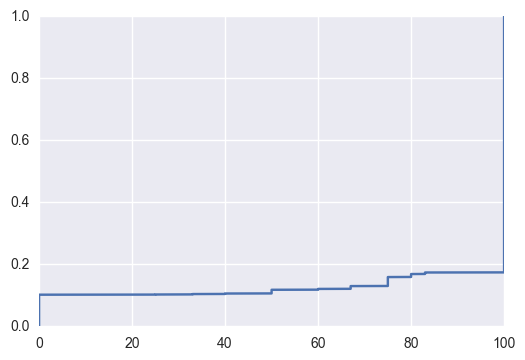

In [200]:
test = sorted(list(ML_five_min_frame['% Observed']))
ind = [i/float(len(test)) for i in range(len(test))]
plt.plot(test,ind)

In [201]:
print "total stations in file: %s" % len(ML_five_min_frame['Station'].unique())

total stations in file: 839


In [202]:
# which stations are always good
mean_df = ML_five_min_frame[['Station', '% Observed']].groupby('Station').mean()

In [203]:
mean_df.sort_values(by='% Observed', ascending=False).head()

,% Observed
Station,
1108429,97.524549
1108597,97.524549
1115929,97.524549
1116139,97.524549
1108486,97.524549


In [204]:
mean_df[mean_df['% Observed'] == 100]

,% Observed
Station,


In [156]:
# look at the station health grouped by station id
counts = ML_five_min_frame.groupby(['Station'])['% Observed'].value_counts()
eq_100 = counts[counts.reset_index(level=0).index == 100]
less_than_100 = counts[counts.reset_index(level=0).index < 100]

In [159]:
print "total counts: %s" % counts.count()
print "# of stations with 100: %s" % eq_100.count()
print "# of stations with less than 100: %s" % less_than_100.count()

total counts: 2992
# of stations with 100: 1279
# of stations with less than 100: 1713


In [92]:
# check for missing files through the year.
days_in_year = 365
days_in_leap = days_in_year + 1
leap_year = [2008, 2012, 2016]

base_path_2016 = '/Users/bohr/workspace/capstone/cohort2/output/station_5min/2016'
base_path_2015 = '/Users/bohr/workspace/capstone/cohort2/output/station_5min/2016'
base_path = base_path_2015

districts = ['d10', 'd11', 'd12', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8']
for district in districts:
    full_path = base_path + '/' + district
    num_files = len([f for f in os.listdir(full_path) if os.path.isfile(os.path.join(full_path, f))])
    print "district: %s num_files: %s percent: %s" % (district, num_files, num_files/float(days_in_leap))

district: d10 num_files: 364 percent: 0.994535519126
district: d11 num_files: 364 percent: 0.994535519126
district: d12 num_files: 364 percent: 0.994535519126
district: d3 num_files: 364 percent: 0.994535519126
district: d4 num_files: 364 percent: 0.994535519126
district: d5 num_files: 364 percent: 0.994535519126
district: d6 num_files: 364 percent: 0.994535519126
district: d7 num_files: 364 percent: 0.994535519126
district: d8 num_files: 364 percent: 0.994535519126


# Check to see how many stations are always down

In [45]:
five_min_frame.columns

Index([u'Timestamp', u'Station', u'District', u'Freeway #', u'Direction',
       u'Lane Type', u'Station Length', u'Samples', u'% Observed',
       u'Total Flow', u'Avg Occupancy', u'Avg Speed', u'Lane 1 Samples',
       u'Lane 1 Flow', u'Lane 1 Avg Occ', u'Lane 1 Avg Speed',
       u'Lane 1 Observed', u'Lane 2 Samples', u'Lane 2 Flow',
       u'Lane 2 Avg Occ', u'Lane 2 Avg Speed', u'Lane 2 Observed',
       u'Lane 3 Samples', u'Lane 3 Flow', u'Lane 3 Avg Occ',
       u'Lane 3 Avg Speed', u'Lane 3 Observed', u'Lane 4 Samples',
       u'Lane 4 Flow', u'Lane 4 Avg Occ', u'Lane 4 Avg Speed',
       u'Lane 4 Observed', u'Lane 5 Samples', u'Lane 5 Flow',
       u'Lane 5 Avg Occ', u'Lane 5 Avg Speed', u'Lane 5 Observed',
       u'Lane 6 Samples', u'Lane 6 Flow', u'Lane 6 Avg Occ',
       u'Lane 6 Avg Speed', u'Lane 6 Observed', u'Lane 7 Samples',
       u'Lane 7 Flow', u'Lane 7 Avg Occ', u'Lane 7 Avg Speed',
       u'Lane 7 Observed', u'Lane 8 Samples', u'Lane 8 Flow',
       u'Lane 8 Avg O

In [47]:
five_min_by_station = five_min_frame[['Station', '% Observed', 'Timestamp']].set_index(['Station'])\
    .groupby(level=0)

In [48]:
station_observed = five_min_by_station.mean()

In [53]:
total = station_observed.count()
always_down = station_observed[station_observed['% Observed'] == 0].count()
print always_down
print "percentage always down: %s" % (always_down/float(total)*100)

% Observed    73
dtype: int64
percentage always down: % Observed    5.126404
dtype: float64
